Rock, Paper, Scissors 

https://www.tensorflow.org/datasets/catalog/rock_paper_scissors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import tensorflow_datasets as tfds
from sklearn.preprocessing import normalize
import cv2
%matplotlib inline

In [ ]:
ds = tfds.load('rock_paper_scissors', split='test')
#our dataset of rock,paper or scissors shown by our participants 
images = tfds.as_dataframe(ds)['image'].to_numpy()
labels = tfds.as_dataframe(ds)['label'].to_numpy()

In [ ]:
def plot(img, cmap='gray'):
    plt.imshow(img.reshape([size,size]), cmap=cmap)
    
def plot_clusters(cluster, cmap='gray', col=3, row=1):
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(row,col, figsize = (4*col,4*row))
    for i in range(col):
        axs[i].imshow(cluster[i].reshape(size,size), cmap=cmap)
        axs[i].set_title(f'Cluster {i + 1}')

## K-means

In [ ]:
def calcSqDistances(X, mu):
     #calculating the distances of our data points from the mu of the cluster 
    N,K = X.shape[0], mu.shape[0]
    sqDmat = np.empty([N,K])
    for k in range(K):
        sqDmat[:,k] = np.linalg.norm(X - mu[k],axis=1)
    return sqDmat

def determineRnk(sqDmat):
    N,K = sqDmat.shape
    R = np.zeros([N,K])
    mins = np.argmin(sqDmat,axis=1)
    for n in range(N):
        R[n,mins[n]] = 1
    return R

def recalcMus(X, gamma):
    #recalculating 
    return gamma.T@X / np.sum(gamma,axis=0)[:,None]

def runKMeans(K,X,ind):
    N,D = X.shape
    mu = X[ind]
    
    maxiters = 1000
    for iter in range(maxiters):
        sqDmat = calcSqDistances(X,mu)
        Rnk = determineRnk(sqDmat)
        mu_old = mu
        mu = recalcMus(X,Rnk)
        if np.sum(np.abs(mu_old.flatten() - mu.flatten())) < 1e-6:
            print(iter)
            break
    return mu

In [ ]:
#initial data formatting (Grayscaling)
size = 300
hands = np.array([cv2.cvtColor(i,cv2.COLOR_RGB2GRAY).flatten() for i in images])
hands.shape

(372, 90000)

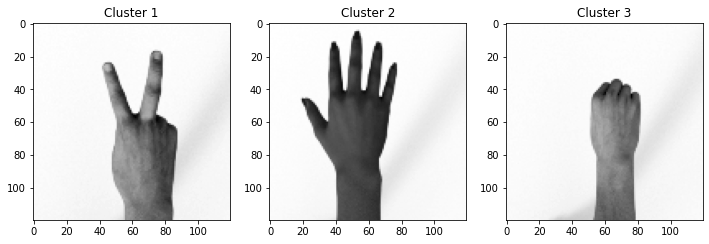

In [ ]:
K = 3
# initializing mu with random images
# ind = np.random.choice(hands.shape[0],K,replace=False)
# initializing mu with representatives (respectively: scissors, paper, rock)
ind = [0,1,4]
plot_clusters(hands[ind])

14


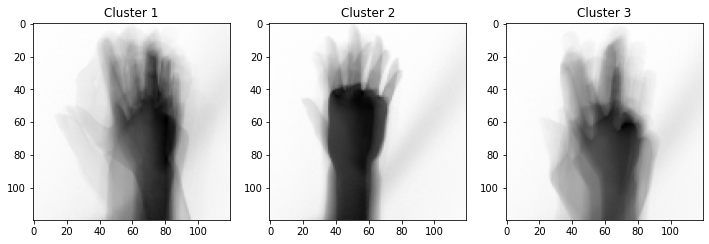

In [ ]:
#running and plotting K-means
KMeans3 = runKMeans(K, hands, ind).reshape(K,size,size)
plot_clusters(KMeans3)

## Mixture of Bernoulli

In [ ]:
def train_EM_MOB(x, pi, mu, K=3, dtype=np.longdouble):
    N = x.shape[0]
    gamma = np.empty([N,K],dtype=dtype)

    max_iter=1000
    for iter in range(max_iter):
        # E step: calculate gamma
        for k in range(K):
            gamma[:,k] = pi[k]*np.prod((mu[k]**x)*(1-mu[k])**(1-x),axis=1)
        gamma = gamma / np.sum(gamma, axis=1, keepdims=True)

        # M step: calculate pi and mu
        mu_old = mu.copy()
        pi = np.sum(gamma, axis=0)
        mu = gamma.T@x / pi[:,None]
        pi = pi / N

        if np.sum(np.abs(mu.flatten() - mu_old.flatten())) < 1e-6:
            print(iter)
            break
    return pi,mu

In [ ]:
# approximately the largest image size we can do with respective dtype
print(np.sqrt(-np.log2(np.finfo(np.float64).tiny)))
print(np.sqrt(-np.log2(np.finfo(np.longdouble).tiny)))

31.96873472629156
127.99218726156686787


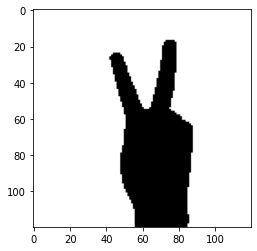

In [ ]:
# don't go higher in case of exceeding the precision
dtype = np.longdouble
size = 120
hands = np.array([cv2.resize(cv2.cvtColor(i,cv2.COLOR_RGB2GRAY),(size,size)).flatten() for i in images])
b = np.zeros(hands.shape,np.bool_)
b[hands>=0.85*255] = 1
plot(b[0])

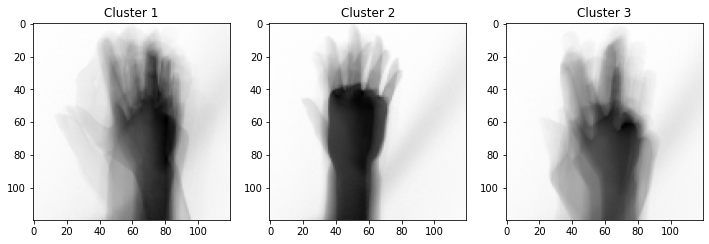

In [ ]:
K,D = (3, size**2)
pi = np.full(K,1/K)
# initializing mu with the K-means results 
mu = dtype([cv2.resize(img,(size,size)).flatten() / 255 for img in KMeans3])
plot_clusters(np.float64(mu))
#Mu for reference

3


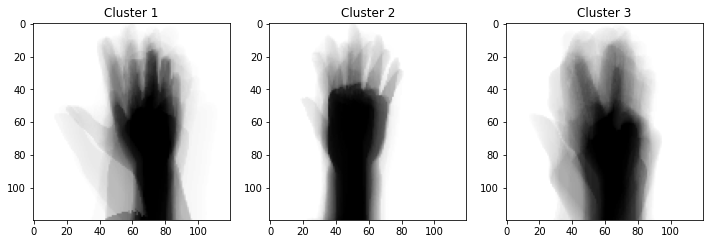

In [ ]:
#BMM using K-means results
pi, mu = train_EM_MOB(b,pi,mu,K,dtype=dtype)
plot_clusters(np.float64(mu))

2


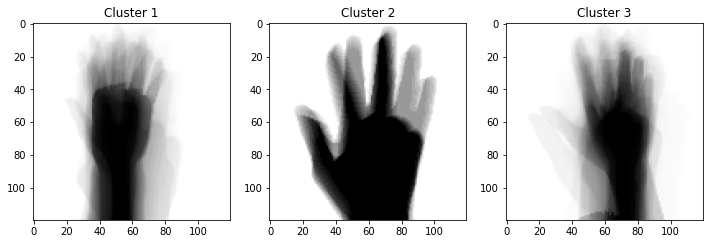

In [ ]:
#initializing mu randomly between [0.3,0.7]
mu = dtype(np.random.uniform(0.3,0.7,(K,D)))
pi, mu = train_EM_MOB(b,pi,mu,K,dtype=dtype)
plot_clusters(np.float64(mu))

## PCA

In [ ]:
def eigsort(V, eigvals):
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.empty((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

In [ ]:
ds = tfds.load('rock_paper_scissors', split='train')
images = tfds.as_dataframe(ds)['image'].to_numpy()
labels = tfds.as_dataframe(ds)['label'].to_numpy()

In [ ]:
size = 300
hands = np.array([cv2.cvtColor(i,cv2.COLOR_RGB2GRAY).flatten() for i in images])
rock, paper, scissors = [hands[labels == 0].T, hands[labels == 1].T, hands[labels == 2].T]

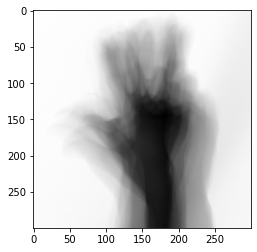

In [ ]:
mean = np.mean(scissors, axis=1, keepdims=True)
plot(mean)

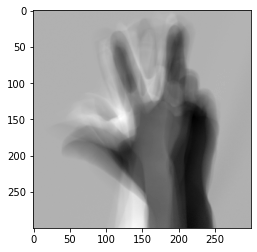

In [ ]:
A = scissors - mean
lambd,V = np.linalg.eig(A.T@A)
V,D = eigsort(V,lambd)
U = A@V
U = normc(U)
plot(U[:,0])

In [ ]:
c = U.T@A[:,[0]]

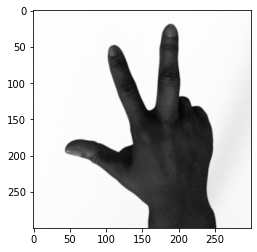

In [ ]:
z = U@c+mean
plot(z)

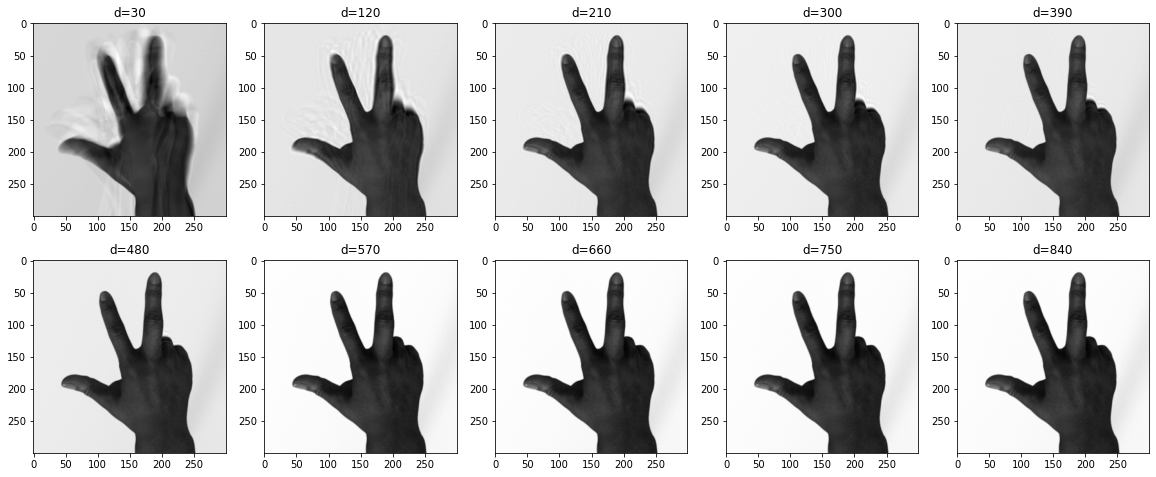

In [ ]:
row,col = (2,5)
fig,axs = plt.subplots(row,col, figsize = (4*col,4*row))
for i in range(0,10):
    d = (i*90)+30
    z = (U[:,:d]@c[:d])+mean
    axs[i//col][i%col].imshow(z.reshape(size,size), cmap='gray')
    axs[i//col][i%col].set_title('d=%s' % (d))

## Autoencoder

Epoch 1/5
75/75 [==============================] - 9s 112ms/step - loss: 52078.9844 - val_loss: 52019.9531
Epoch 2/5
75/75 [==============================] - 8s 110ms/step - loss: 52008.4258 - val_loss: 52001.1250
Epoch 3/5
75/75 [==============================] - 8s 111ms/step - loss: 51997.9023 - val_loss: 51995.4297
Epoch 4/5
75/75 [==============================] - 8s 110ms/step - loss: 51993.9570 - val_loss: 51992.7109
Epoch 5/5
75/75 [==============================] - 8s 112ms/step - loss: 51991.9023 - val_loss: 51991.1992


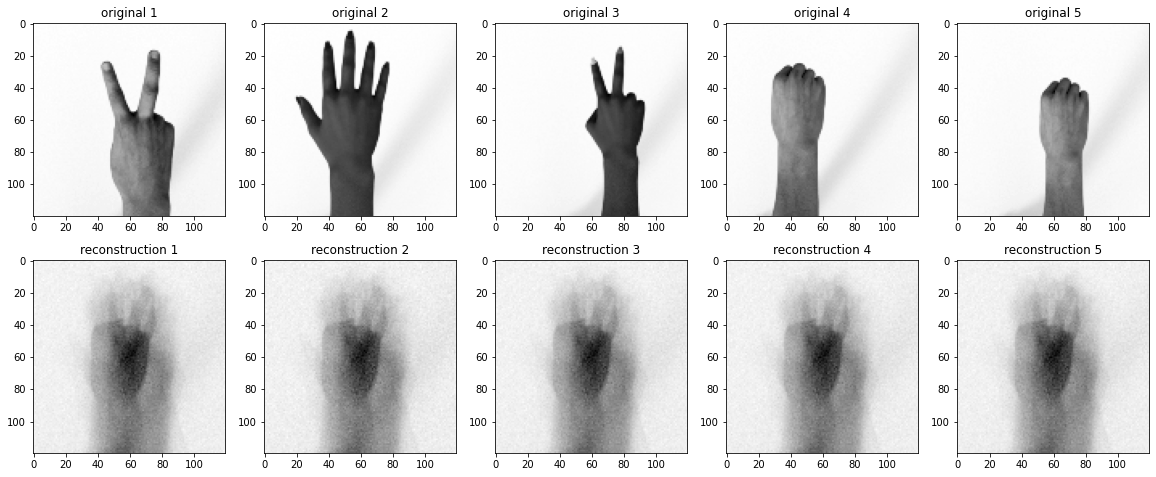

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers

latent_dim = 1250 # lower-dimensional latent space

# construct layers
x = keras.Input(shape=(size**2,))
h = layers.Dense(latent_dim, activation='sigmoid')(x)
y = layers.Dense(size**2, activation='sigmoid')(h)

# construct model
autoencoder = keras.Model(x,y)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train model
autoencoder.fit(hands, hands, epochs=5, batch_size=5, shuffle=True,
                validation_data=(hands, hands))

# run on five examples
z = autoencoder.predict(hands[:5])

# plot original/reconstruction pairs
row,col = (2,5)
fig,axs = plt.subplots(row,col, figsize = (4*col,4*row))
for i in range(col):
    axs[0][i].imshow(hands[i].reshape(size,size), cmap='gray')
    axs[0][i].set_title('original %s' % (i+1))
    axs[1][i].imshow(z[i].reshape(size,size), cmap='gray')
    axs[1][i].set_title('reconstruction %s' % (i+1))